In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import importlib

from umap import UMAP
from deeptime.clustering import KMeans
from deeptime.markov.msm import MarkovStateModel
import pickle

import sys
sys.path.append('../')
from src.piece_functions import generate_random_trajectory
from src.embedding import Embedding
from src.markov_analysis import Markov
from src.trajectory_utils import entropy_rate

import crisp_pccap
importlib.reload(crisp_pccap)
from crisp_pccap import crisp_PCCAp


/mnt/hcleroy/anaconda3/envs/dt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
names = ['persistent_straight','stereotypes4']#,'stereotypes2','stereotypes4','straight_helix']
data,indices = list(),list()
embs,mkvs= list(),list()
cluster_centers=list()
for name in names:
    data.append(np.load('../data/toy_model/processed/umap_points_'+name+'.npy'))
    try:
        indices.append(np.load('../data/toy_model/processed/umap_indices_'+name+'.npy'))
    except:
        indices = np.arange(0,data.__len__(),1)
    with open('../data/toy_model/processed/embedding_'+name+'.pkl', "rb") as f:
        embs.append(pickle.load(f))
    with open('../data/toy_model/processed/markov_'+name+'.pkl', "rb") as f:
        mkvs.append(pickle.load(f))
    cluster_centers.append(np.load('../data/toy_model/processed/umap_centers_'+name+'.npy'))

/tmp/ipykernel_40110/1026586755.py:12: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  embs.append(pickle.load(f))
/tmp/ipykernel_40110/1026586755.py:14: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the c

In [8]:
for i in range(embs.__len__()):
    print(embs[i].K)
    print(embs[i].n_clusters)

15
50
15
50


In [10]:
Ks = [5,20]
for i in range(embs.__len__()):
    embs[i].make_embedding(K=5)
    embs[i].make_cluster(n_clusters=100)

In [11]:
for i in range(embs.__len__()):
    mkvs[i] = Markov(embs[i],tau=10)
    mkvs[i].make_transition_matrix()
    mkvs[i].reversibilized_matrix()

In [12]:
data = list()
for i in range(embs.__len__()):
    reducer = UMAP(
            n_neighbors=15,
            min_dist=0.1,
            n_components=2,
            metric="euclidean",
        )
    data.append(reducer.fit_transform(embs[i].flatten_embedding_matrix))

In [19]:
Memberships = list()
Hs = list()
PCCAs = list()
clusters_size = [2,3,5,7,9,10,15,20,25,30]
for j in range(mkvs.__len__()):
    print('mkv model number :',j)
    membership = list()
    hs = list()
    pccas = list()
    for i in clusters_size:
        print('cluster size', i)
        pcca = crisp_PCCAp(mkvs[j].Pr,n_clusters=i)
        pccas.append(pcca)
        hs.append(pcca.coarse_entropy_rate())
    PCCAs.append(pccas)
    Hs.append(hs)
    

mkv model number : 0
cluster size 2
cluster size 3
cluster size 5
cluster size 7
cluster size 9
cluster size 10
cluster size 15
cluster size 20
cluster size 25
cluster size 30
mkv model number : 1
cluster size 2
cluster size 3
cluster size 5
cluster size 7
cluster size 9
cluster size 10
cluster size 15
cluster size 20
cluster size 25
cluster size 30


Text(0, 0.5, '# size of the partition')

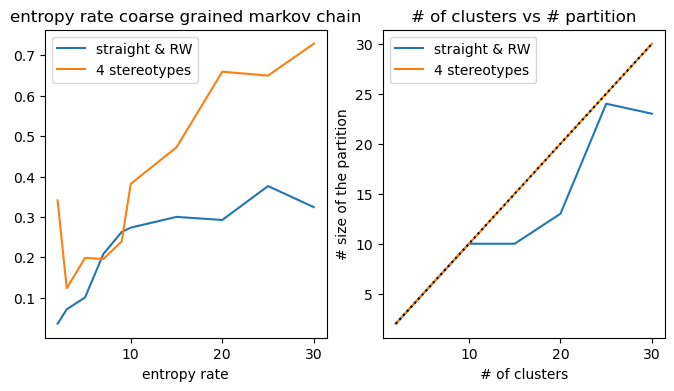

In [20]:
fig, ax = plt.subplots(ncols = 2, figsize=(8,4))
ax[0].plot(clusters_size,Hs[0], label = 'straight & RW')
ax[0].plot(clusters_size,Hs[1], label = '4 stereotypes')
ax[0].legend()
ax[0].set_title('entropy rate coarse grained markov chain')
ax[0].set_xlabel('# of clusters')
ax[0].set_xlabel('entropy rate')

state_size_1 = [pcca.res.chi_crisp.shape[1] for pcca in PCCAs[0]]
state_size_2 = [pcca.res.chi_crisp.shape[1] for pcca in PCCAs[1]]

# after converting fuzzy to crisp membership, some clusters turns out to be empty. We look at the real partition size.
ax[1].plot(clusters_size,state_size_1,label='straight & RW')
ax[1].plot(clusters_size,state_size_2, label='4 stereotypes')
ax[1].plot(clusters_size,clusters_size,color='black',linestyle=':')

ax[1].legend()
ax[1].set_title('# of clusters vs # partition')
ax[1].set_xlabel('# of clusters')
ax[1].set_ylabel('# size of the partition')

In [15]:
Fuzzylist = list()
for pcca in PCCAs[0]:
    #print(pcca.res.chi_soft.shape)
    Fuzzy = np.zeros(pcca.res.chi_soft.shape[1],dtype=float)
    #count = np.zeros(pcca.res.chi_soft.shape[1],dtype=int)
    for i in range(pcca.res.chi_soft.shape[0]):
        for j in range(pcca.res.chi_soft.shape[1]):
            Fuzzy[j]+=pcca.res.chi_soft[i,j]
    Fuzzylist.append(Fuzzy/100.)
    

In [16]:
cluster_entropy = np.zeros(Fuzzylist.__len__(),dtype=float)
for i in range(Fuzzylist.__len__()):
    for j in range(Fuzzylist[i].shape[0]):
        #if Fuzzylist[i][j] > 0:
        cluster_entropy[i] -= Fuzzylist[i][j]*np.log(Fuzzylist[i][j])

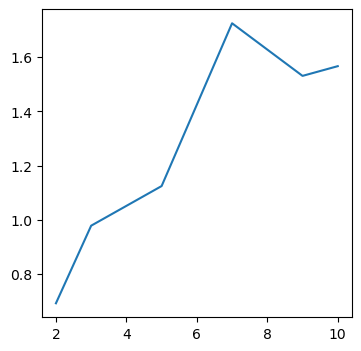

In [18]:
fig, ax = plt.subplots(ncols = 1, figsize=(4,4))
ax.plot(clusters_size,cluster_entropy)

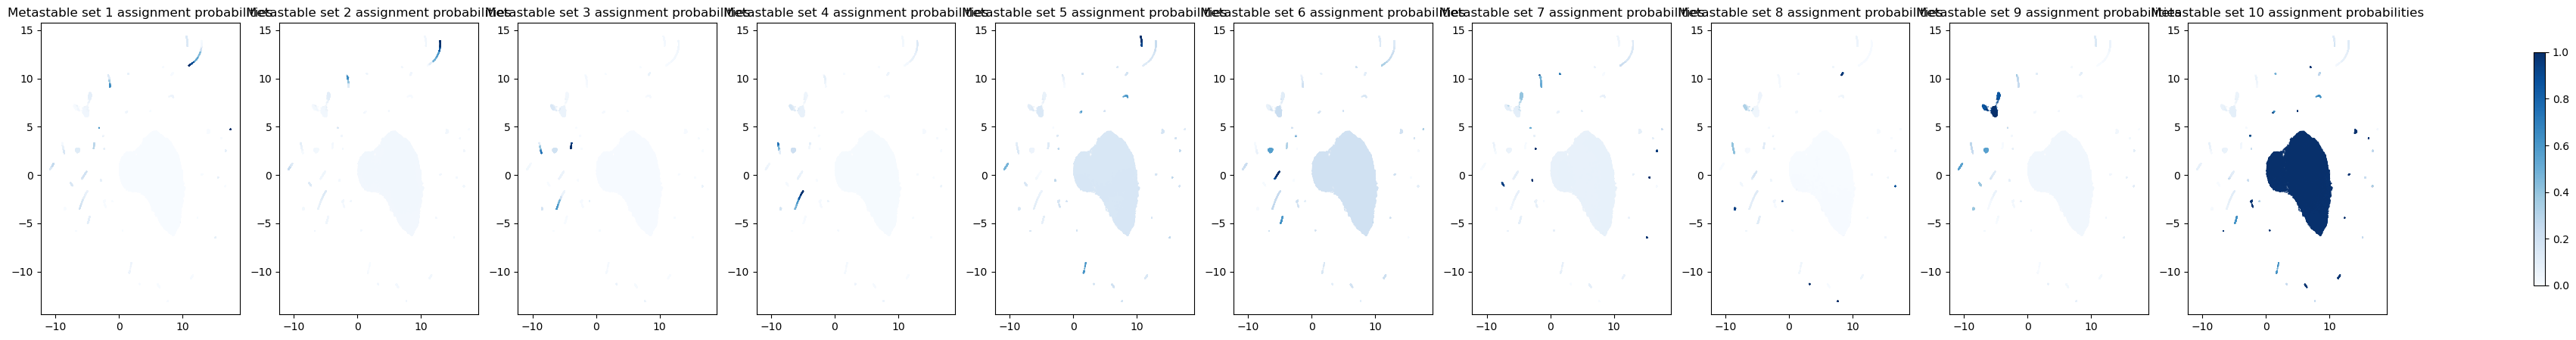

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(50, 5))

assignments = embs[0].labels
for i in range(len(axes)):
    ax = axes[i]
    ax.set_title(f"Metastable set {i+1} assignment probabilities")

    ax.scatter(data[0][:,0],data[0][:,1],s=0.1, c=pcca.memberships[assignments, i], cmap=plt.cm.Blues)
norm = Normalize(vmin=0, vmax=1)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues), ax=axes, shrink=.8)

In [ ]:
fig, axes = plt.subplots(2, 10, figsize=(50, 10))

assignments = embs[0].labels
for i in range(axes.shape[1]):
    ax = axes[0,i]
    ax.set_title(f"Metastable set {i+1} assignment probabilities")
    ax.scatter(data[1][:,0],data[1][:,1],s=0.1, c=pcca.memberships[assignments, i], cmap=plt.cm.Blues)
    
    ax = axes[1,i]
    ax.scatter(data[1][:,0],data[1][:,1],s=0.1, c=pccap_crisps[0]._result.chi_crisp[assignments, i], cmap=plt.cm.Blues)
norm = Normalize(vmin=0, vmax=1)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues), ax=axes, shrink=.8)